<img src="https://www.rochester.edu/assets/images/ur-logo.svg">

# <center>[CSC 249/449: Machine Vision](https://www.cs.rochester.edu/~cxu22/t/249S22/)</center>


1. Make sure you fill in all cells contain `YOUR CODE HERE` or `YOUR ANSWER HERE`.
2. After you finished, `Restart the kernel & run` all cell in order.
---------


# Convolutional Neural Network
----
In this notebook, you will experience how to implement convolution and build your own CNN for image classification task.


In [1]:
# import packages
import csc249
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

## Implement convolution (10 points)

Before walking into the CNN part, you will first implement one of its core function -- **2D convolution**. For this problem you are not allowed to use pyotrch package. This will help you gain first-hand experience with how to implement forward functions of 2D convolutional layer. 

To keep the consistency with CNN:     

1. The operation should work for 3D image tensor of shape (C,H,W) where C denotes the number of channels.   
2. The operation should support **stride and padding**.   
3. [useful link](https://cs231n.github.io/convolutional-networks/)

Hint:
- First, do the padding and compute the output shape based on the kernel, padding and stride size.
- Then, run convolution over all the pixels to get the output.


In [2]:
def Conv2D(img, kernel, bias, stride, padding):
    """2D convolutional operation.
    
    Arguments
    ---------
        img : np.array
            A 3D array of shape (C,H,W).
        kernel : np.array
            the weights of the kerel. 
            A 4D array of shape (out_channels, in_channels, kernel_height, kernel_width).
        bias : np.array
            the biases of the layer. 
            A 1D array of shape (out_channels).
        strides : tuple
            the strides of the convolution operation. 
            A tuple of shape (height_stride, width_stride).
        padding : tuple
            the number of zero paddings along the height and width. 
            A tuple of shape (height_padding, width_padding).

        kernel_size = kernel.shape
        stride = (stride, stride) if type(stride) == int else stride
        padding = (padding, padding) if type(padding) == int else padding


    Returns:
    --------
        The output of the layer. 
        A 3D array of shape (out_channels, out_heights, out_weights).
    """
    # 1. padding
    # YOUR CODE HERE
    out_chan = len(kernel)
    in_chan = len(kernel[0])
    kernel_height = len(kernel[0][0])
    kernel_width = len(kernel[0][0][0])
    if (type(padding) == int):
        height_padding = padding
        width_padding = padding
    else:
        height_padding = padding[0]
        width_padding = padding[1]
    padded_img = np.pad(img, ((0, 0), (height_padding, height_padding), (width_padding, width_padding)))
    #raise NotImplementedError()
    
    # 2. conv operation
    # YOUR CODE HERE
    new_C = len(padded_img)
    new_H = len(padded_img[0])
    new_W = len(padded_img[0][0])
    if (type(stride) == int):
        height_stride = stride
        width_stride = stride
    else: 
        height_stride = stride[0]
        width_stride = stride[1]
    conv_result = []
    for k in range(out_chan):
        ker = kernel[k, :, :, :]
        bias_comp = bias[k]
        temp1 = []
        for i in range(new_H // height_stride - 1):
            temp2 = []
            for j in range(new_W // width_stride):
                #Take out parts to be convoluted with kernel
                hstart = height_stride*i
                wstart = width_stride*j
                hend = hstart + kernel_height
                wend = wstart + kernel_width
                if (hend <= new_H) and (wend <= new_W):
                    img_convo = padded_img[:, hstart:hend, wstart:wend]
                    conv_comp = np.sum(img_convo * ker) + bias_comp
                    temp2.append(conv_comp)
            temp1.append(temp2)
        conv_result.append(temp1)
    conv_result = np.array(conv_result)
    return conv_result
    #raise NotImplementedError()

Run the cell below to validate the correctness of your implementation.

In [3]:
with open(csc249.data/'conv_cases.pkl', 'rb') as conv_f:
    conv_cases = pickle.load(conv_f)
    for case in conv_cases:
        weight = case['weight']
        bias = case['bias']
        x = case['x']
        out = case['out']
        stride = case['stride']
        pad = case['pad']
        conved= Conv2D(x,weight,bias,stride,pad)
        assert np.allclose(conved, out),'not pass'
    print("Implemented Correctly")

Implemented Correctly


## CNN with Image Classification (30 points)

In this problem, you will need to build your own CNN to classify the acutal class an image belongs to. The overall pipeline is decomposed to the following steps:

1. Prepare the image classificatin dataset
2. Define your convolutional neural network (15 points)
3. Define criterion and optimizer
3. Train your CNN (10 points)
4. Evaluate your model's performance (5 points)

For this part, you are required to use **pytorch** for development.


### 1. Perpare dataset 

Here you will use a ten-class image dataset for classification.

Files already downloaded and verified
Files already downloaded and verified


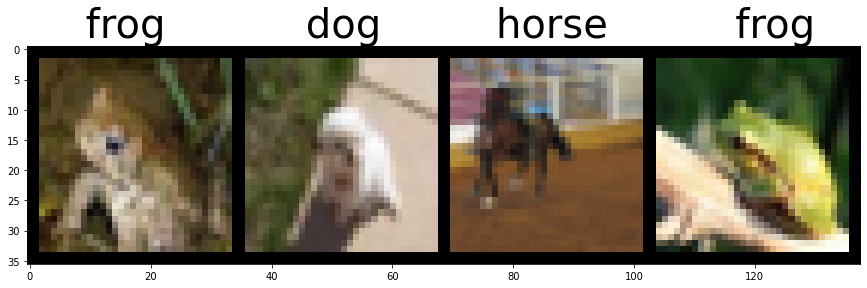

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root=csc249.data, train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)
valset = torchvision.datasets.CIFAR10(root=csc249.data, train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.figure(figsize=(16,4))
plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy(), (1, 2, 0)))
plt.title('         '.join('%5s' % classes[labels[j]] for j in range(4)),fontsize=40,)
plt.show()

### 2. Define Your CNN (15 points)
- Now decide your own CNN. Note that you can choose your own parameter (e.g., the number of layers, hidden channels, kernel size...) to get a good result. Since no arguements will be passed into the initialization of ``Net()`` this time, please keep all the parameters embedded.
    - You can call **nn.Conv2d**. Refer to https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html for more details.
    - Use `LeakyReLU` as your activation function.
    - With maxpooling in between. (Reference: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- Following with 2 FC layers for classification.
    - Be care of the number of final output channels! You are working on a 10-class clssification problem.


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # YOUR CODE HERE
        self.relu = torch.nn.LeakyReLU()
        self.conv1 = torch.nn.Conv2d(3, 8, 5) 
        self.maxpool = torch.nn.MaxPool2d(2, 2) 
        self.conv2 = torch.nn.Conv2d(8, 16, 5)
        self.fc1 = torch.nn.Linear(400, 120) 
        self.fc2 = torch.nn.Linear(120, 160)
        self.fc3 = torch.nn.Linear(160, 10)
        #raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        x1 = self.conv1(x)
        a1 = self.relu(x1)
        z1 = self.maxpool(a1)
        #print(z1.shape)
        x2 = self.conv2(z1)
        #print(x2.shape)
        a2 = self.relu(x2)
        z2 = self.maxpool(a2)
        #print(z2.shape)
        z2 = z2.flatten(1)
        #print(z2.shape)
        x3 = self.fc1(z2)
        #print(x3.shape)
        a3 = self.relu(x3)
        x4 = self.fc2(a3)
        #print(x4.shape)
        a4 = self.relu(x4)
        x5 = self.fc3(a4)
        #print(x5.shape)
        return x5
        #raise NotImplementedError()

### 3. Define criterion, net and optimizer

For details please refer to https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [6]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


### 4. Training (10 points)
The same as before, for training, 

- call the network forward pass to get the predictions
- calculate the loss wrt the ground-truth 
- backpropagate the loss to optimize the network.
- compute accuracy at the end of **each epoch**

Plot the loss for each epoch which is defined as the average of all sample's loss within one epoch  

Hint (make sure you are on the GPU machine, otherwise ignore these): use below snippet to put data on GPU. You can also use the command ``nvidia-smi`` to check if there is enough GPU memory to run your program. 

>```python
>net = net.cuda()
>inputs = inputs.cuda()
>labels = labels.cuda()
>```

In [ ]:
# comment this line of code if not on gpu
net = net.cuda()

for epoch in range(10):  # loop over the dataset multiple times
# YOUR CODE HERE
    for step, (train_feat, train_lab) in enumerate(trainloader):
        train_feat = train_feat.cuda()
        train_lab = train_lab.cuda()
        optimizer.zero_grad()
        train_out = net(train_feat)
        _, train_pred = torch.max(train_out, 1)
        loss = criterion(train_out, train_lab)
        loss.backward()
        optimizer.step()
    print('Training complete')
#raise NotImplementedError()

Training complete
Training complete
Training complete
Training complete
Training complete
Training complete
Training complete


### 5. Evaluation (5 points)

Run over all the validation samples to calculate the number of correct predictions. You are expected to get > 50% accuracy.

In [ ]:
correct = 0
total = 0

# YOUR CODE HERE
with torch.no_grad():
    for step, (valid_feat, valid_lab) in enumerate(valloader):
        valid_feat = valid_feat.cuda()
        valid_lab = valid_lab.cuda()
        prediction = net(valid_feat)
        y = valid_lab
        _, prediction = torch.max(prediction, 1)
        for lab, pred in zip(y, prediction):
            total += 1
            if (lab == pred):
                correct += 1
#raise NotImplementedError()
        
print(f'Accuracy of the network on the 10000 validation images: {100 * correct // total} %')

# Submission

1. At the menubar, click `Kernel`$\rightarrow$ `Restart & Run All`
2. Download the zip file and upload via blackboard
   
1% deduction of late assignment total score per hour passing the deadline.

In [ ]:
import csc249
csc249.make_submission()